In [1]:
import sys

robot_packages = "/opt/openrobots/lib/python3.7/site-packages/"
if robot_packages not in sys.path:
    sys.path.insert(0, "/opt/openrobots/lib/python3.7/site-packages/")
else:
    print('robot_packages already in sys.path')

iter     cost         stop         grad         xreg         ureg       step    ||ffeas||
   0  1.65689e+02  3.06065e+03  9.85934e+02  1.00000e-09  1.00000e-09  0.5000  6.12882e-05
   1  1.30773e+02  5.41693e+06  3.31360e+02  1.00000e-09  1.00000e-09  1.0000  3.06441e-05
   2  2.13625e-02  1.72347e+07  2.61528e+02  1.00000e-09  1.00000e-09  1.0000  0.00000e+00
   3  8.62699e-03  1.77841e+03  2.54280e-02  1.00000e-09  1.00000e-09  1.0000  0.00000e+00
   4  8.61343e-03  8.95243e-05  1.97409e-05  1.00000e-09  1.00000e-09  1.0000  0.00000e+00
   5  8.61124e-03  8.05604e-10  3.14884e-06  1.00000e-09  1.00000e-09  1.0000  0.00000e+00


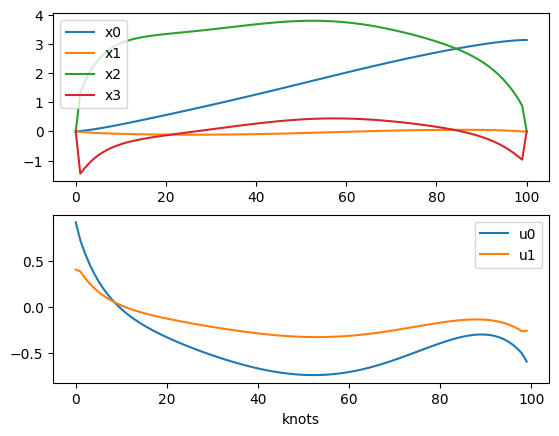

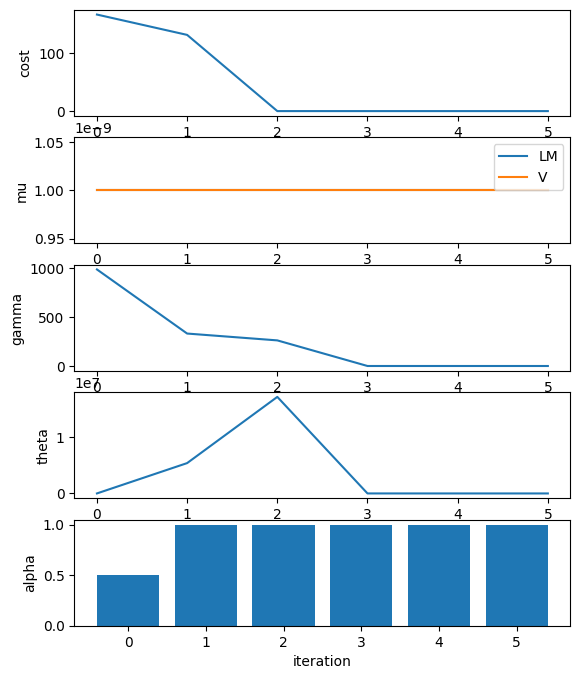

In [4]:
import os
import sys
import crocoddyl
import numpy as np
import example_robot_data
from crocoddyl.utils.pendulum import CostModelDoublePendulum, ActuationModelDoublePendulum

os.environ['CROCODDYL_PLOT'] = 'True'
WITHDISPLAY = 'display' in sys.argv or 'CROCODDYL_DISPLAY' in os.environ
WITHPLOT = 'plot' in sys.argv or 'CROCODDYL_PLOT' in os.environ

# Loading the double pendulum model
pendulum = example_robot_data.load('double_pendulum')
model = pendulum.model
state = crocoddyl.StateMultibody(model)

# Create actuation model for the planar 2R robot (only first two joints)
actuation = crocoddyl.ActuationModelFull(state)

# Cost models for the planar 2R robot
nu = actuation.nu
runningCostModel = crocoddyl.CostModelSum(state, nu)
terminalCostModel = crocoddyl.CostModelSum(state, nu)

# Adding a quadratic velocity cost to the running cost model
velResidual = crocoddyl.ResidualModelControl(state, nu)
velActivation = crocoddyl.ActivationModelQuad(nu)
velCost = crocoddyl.CostModelResidual(state, velActivation, velResidual)
runningCostModel.addCost("velCost", velCost, 1e-6)

xGoal = state.zero()
xGoal[:2] = np.array([3.14, 0.])

xResidual = crocoddyl.ResidualModelState(state, xGoal, nu)
xActivation = crocoddyl.ActivationModelQuad(state.ndx)
uResidual = crocoddyl.ResidualModelControl(state, nu)
xRegCost = crocoddyl.CostModelResidual(state, xActivation, xResidual)
uRegCost = crocoddyl.CostModelResidual(state, uResidual)

dt = 1e-2

runningCostModel.addCost("uReg", uRegCost, 1e-4 / dt)
runningCostModel.addCost("xGoal", xRegCost, 1e-5 / dt)
terminalCostModel.addCost("xGoal", xRegCost, 100.)

runningModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuation, runningCostModel), dt)
terminalModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuation, terminalCostModel), dt)

# Creating the shooting problem and the FDDP solver
T = 100
x0 = np.array([0, 0., 0., 0.])
problem = crocoddyl.ShootingProblem(x0, [runningModel] * T, terminalModel)
solver = crocoddyl.SolverFDDP(problem)

cameraTF = [1.4, 0., 0.2, 0.5, 0.5, 0.5, 0.5]
if WITHDISPLAY and WITHPLOT:
    display = crocoddyl.GepettoDisplay(pendulum, 4, 4, cameraTF, False)
    solver.setCallbacks([crocoddyl.CallbackLogger(), crocoddyl.CallbackVerbose(), crocoddyl.CallbackDisplay(display)])
elif WITHDISPLAY:
    display = crocoddyl.GepettoDisplay(pendulum, 4, 4, cameraTF, False)
    solver.setCallbacks([crocoddyl.CallbackVerbose(), crocoddyl.CallbackDisplay(display)])
elif WITHPLOT:
    solver.setCallbacks([crocoddyl.CallbackLogger(), crocoddyl.CallbackVerbose()])
else:
    solver.setCallbacks([crocoddyl.CallbackVerbose()])

# Solving the problem with the FDDP solver
solver.solve()

# Plotting the entire motion
if WITHPLOT:
    log = solver.getCallbacks()[0]
    crocoddyl.plotOCSolution(log.xs, log.us, figIndex=1, show=False)
    crocoddyl.plotConvergence(log.costs, log.u_regs, log.x_regs, log.grads, log.stops, log.steps, figIndex=2)

# Display the entire motion
if WITHDISPLAY:
    display = crocoddyl.GepettoDisplay(pendulum, floor=False)
    display.displayFromSolver(solver)



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6c93d499-49c8-4f8f-ae8a-bb30b3a728a5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>